In [1]:
import numpy as np
import json
import codecs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from model import my_aggclustering3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
msdat_dir = '/home/hpms/Microsoft.IoT-Dump1.json'
with codecs.open(msdat_dir, 'r', 'utf-8-sig') as f:
    msdat = json.load(f)
msdat = pd.DataFrame(msdat)
msdat['Commands'] = [tuple(session) for session in msdat['Commands']]
msdat = msdat.drop_duplicates(subset='Commands').reset_index(drop=True)  # drop duplicates
msdat['Commands'] = [list(session) for session in msdat['Commands']]
msdat['Commands Length'] = [len(session) for session in msdat['Commands']]
msdat = msdat.sort_values(by='FirstSeen').reset_index(drop=True)

In [3]:
n_session = len(msdat)

In [4]:
alpha_cluster = 0.1
cluster_threshold = -0.2
alpha_label = 0.1
seq_len = 12

In [6]:
my_agg = my_aggclustering3(msdat[:int(n_session*0.9)], alpha_cluster, cluster_threshold, alpha_label, seq_len)
for depth in range(6):
    my_agg.fit()
with open('agg3_data/aggclustering_9010.pkl', 'wb') as f:
    pickle.dump(my_agg, f, protocol=4)

Depth 1: 16 clusters exist. Time spent 51.91s.
Depth 2: 57 clusters exist. Time spent 449.92s.
Depth 3: 68 clusters exist. Time spent 763.79s.
Depth 4: 75 clusters exist. Time spent 763.72s.
Depth 5: 76 clusters exist. Time spent 754.71s.
Depth 6: 93 clusters exist. Time spent 1041.53s.


In [7]:
with open('agg3_data/aggclustering_9010.pkl', 'rb') as f:
    my_agg = pickle.load(f)
for depth in range(2):
    my_agg.fit()
with open('agg3_data/aggclustering_9010.pkl', 'wb') as f:
    pickle.dump(my_agg, f, protocol=4)

Depth 7: 104 clusters exist. Time spent 1369.38s.
Depth 8: 108 clusters exist. Time spent 1473.26s.


In [5]:
with open('agg3_data/aggclustering_9010.pkl', 'rb') as f:
    my_agg = pickle.load(f)

In [6]:
from utils import extract, find_session_rank

In [7]:
def predict(self, df, depth):
    if self.depth == 0:
        raise ValueError('No training performed.')
    # ensure the length of session is not too small
    new_df = df.loc[df['Commands Length'] >
                    self.seq_len].reset_index(drop=True)
    sessions_list, _ = extract(new_df)
    score_list = [-1 for i in range(len(sessions_list))]
    session_rank_list = find_session_rank(sessions_list, self.seq_rank_list)

    for i, session in enumerate(sessions_list):
        rank = session_rank_list[i]
        for key, val in zip(self.init_commands_clusters[depth-1], self.posteriors[depth-1]):
            if tuple(session[:depth]) in key:
                val = np.append(val, self.alpha_label)
                score_list[i] = val[rank]/sum(val)
                break

    score_list = [score if score != -1 else 1 /
                  (max(self.sessions_rank_list)+1) for score in score_list]

    return score_list

In [8]:
score_lists = []
for depth in range(my_agg.depth):
    score_lists.append(predict(my_agg, msdat[int(n_session*0.9):], depth+1))

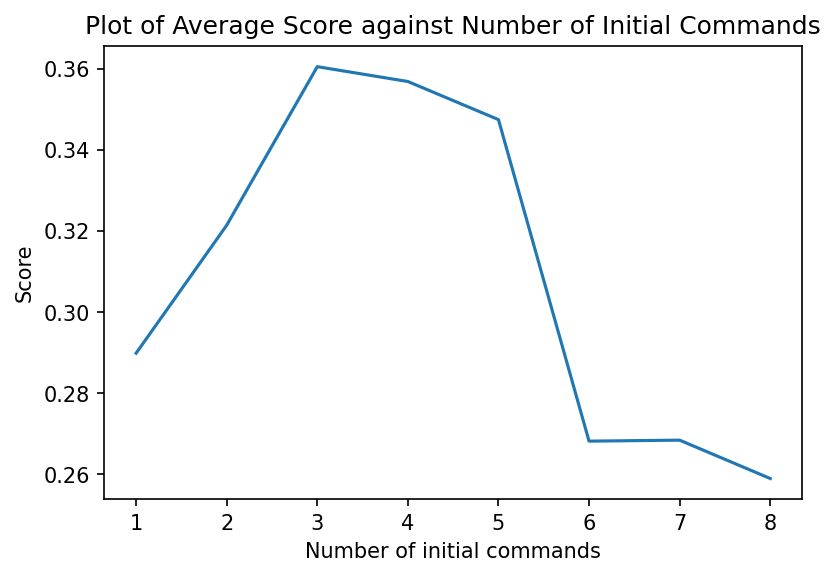

In [16]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
sns.lineplot(x = [i for i in range(1,9)], y = [np.mean(score) for score in score_lists],ax=ax)
ax.set(title='Plot of Average Score against Number of Initial Commands',
       xlabel='Number of initial commands',
       ylabel='Score'
      )
plt.show()